In [37]:
%load_ext autoreload
%autoreload 2

import pytorch_lightning as pl
from torchvision import datasets, transforms 
from torch.utils.data import random_split, DataLoader, Dataset
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import os
import torch
import torch.nn.functional as F
import random
import numpy as np
import torch.nn as nn
from PIL import Image
import timm
from tqdm import tqdm
import shutil
from datetime import datetime
from pytz import timezone 
# import warnings
# warnings.filterwarnings("ignore")


from skew_correction.helper import *
from skew_correction.data import plot_random_images
from skew_correction.model import total_params, print_metrics_on_epoch_end, get_acc, TimmRegressor
from skew_correction.constants import image_size

root_dir = "/".join( os.getcwd().split("/")[:-1])
data_dir = os.path.join(root_dir, "data")
root_dir

device = "cuda" if torch.cuda.is_available() else "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## prepare data (only run once, DO NOT RUN ANYMORE )

In [30]:
from PIL import Image
np.array(Image.open("/home/deepam_minda_farmart_co/fmt/skew_correction/data/rotated/rdocuments/train_/Image-0--8Image_33.jpg")).shape

(650, 470)

In [3]:
## split files from one folder into 2 tran-test

def split_files(src_dir, dest_dir, train_size):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    all_files = os.listdir(src_dir)
    random.shuffle(all_files)
    
    total_files = len(all_files)
    train_count = int(total_files * train_size)
    
    train_files = all_files[:train_count]
    test_files = all_files[train_count:]
    
    train_dir = os.path.join(dest_dir, "train_")
    test_dir = os.path.join(dest_dir, "test_")
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    copy_files(src_dir, train_dir, train_files)
    copy_files(src_dir, test_dir, test_files)
    return train_files, test_files

def move_files(src_dir, dest_dir, files):
    for file in files:
        src_path = os.path.join(src_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.move(src_path, dest_path)

def copy_files(src_dir, dest_dir, files):
    for file in files:
        src_path = os.path.join(src_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.copy(src_path, dest_path)

# Example usage
src_directory = os.path.join(data_dir, "original/train")
dest_directory = os.path.join(data_dir, "original/")
train_ratio = 0.8  # 80% for training, 20% for testing

## train_files, test_files = split_files(src_directory, dest_directory, train_ratio)


In [4]:
def prepare_data(src_dir, dest_dir, save_csv=True, multiple=2):  
    """
    this function takes input path of a dir whoch contains 0 degree images and rotates them to a random angle between 
    -180 and +180 and stores them in the output dir. also makes a data.csv containing file name and angles in the output folder.
    """
    
    os.makedirs(dest_dir, exist_ok=True)

    save_dict = {
        'filepath': [],
        'angle': []
    }
    

    org_img_paths = get_images_in_dir(src_dir, return_path=True)
    print(f"There are {len(org_img_paths)} images in src_folder. Preparing rotated images. \
        \nmultiple={multiple}. hence there will be {multiple*len(org_img_paths)} images")
    
    for num in range(multiple):
        for img_path in tqdm(org_img_paths):
            img = read_raw_image(img_path, mode='L')
            
            # select random angle and rotate
            angles = np.arange(-180, 180)
            angle = random.choice(angles)
            img = img.rotate(angle, expand=True)
            
            # save rotated img in dest folder
            img_name, ext = img_path.split('/')[-1].split('.')
            save_filename = f"{img_name}_{angle}.{ext}"
            dest_path = os.path.join(dest_dir, save_filename)       
            img.save(dest_path)
            
            if os.path.exists(dest_path):
                save_dict["filepath"].append(dest_path)
                save_dict["angle"].append(angle)
    
    if save_csv==True:
        pd.DataFrame(save_dict).to_csv(os.path.join(dest_dir, "data.csv"), index=None)

    return 1

In [5]:
# for folder in ['train', 'test']:

#     src_dir = os.path.join(root_dir, f"data/original/{folder}/")
#     dest_dir = os.path.join(root_dir, f"data/rotated/{folder}/")
    
#     if folder=="train": 
#         multiple=2
#     else:
#         multiple=1
#     prepare_data(src_dir, dest_dir, save_csv=True, multiple=multiple)

In [34]:
src_dir = os.path.join(root_dir, f"data/original/train/")
dest_dir = os.path.join(root_dir, f"data/rotated/temp_folder/")

prepare_data(src_dir, dest_dir, save_csv=True, multiple=1)

There are 763 images in src_folder. Preparing rotated images.         
multiple=1. hence there will be 763 images


 11%|█         | 82/763 [00:09<01:15,  9.07it/s]

Error in exif_transpose


100%|██████████| 763/763 [01:31<00:00,  8.31it/s]


1

### r-docs splitting

In [7]:
## split files
src_dir = os.path.join(root_dir, f"data/rotated/rdocuments/")
dest_dir = os.path.join(root_dir, f"data/rotated/rdocuments/")
# split_files(src_dir, dest_dir, train_size=0.8)

In [8]:
def find_second_hyphen_index(number):
    first_hyphen_index = number.find('-')
    second_hyphen_index = number.find('-', first_hyphen_index + 1)
    return second_hyphen_index


# text = "Image-21--20Image_22.jpg"
# text = text[find_second_hyphen_index(text)+1:]
# text[:text.find('I')]

In [9]:
# prepare csv
# dir_path = os.path.join(root_dir, f"data/rotated/rdocuments/test_")
# paths = get_images_in_dir(dir_path, return_path=True)

# angles = []
# for path in paths:
#     slug = path.split('/')[-1][:-4]
#     slug = slug[find_second_hyphen_index(slug)+1:]
#     angle = int(slug[:slug.find('I')])
#     angles.append(angle)
# # angles
# df = pd.DataFrame({'filepath': paths, 'angle':angles})
# # df.values
# df.to_csv(os.path.join(dir_path, 'data.csv'))

## scaling angles

In [5]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
df = pd.read_csv(os.path.join(root_dir, "data/rotated/rdocuments/train_/data.csv"))
df['scaled_angle'] = scaler.fit_transform(df['angle'].values.reshape(-1, 1)) 
# df['angle']
# df.values
# df.to_csv(os.path.join(data_dir, 'rotated/rdocuments/train_scaled.csv'))


In [11]:

test_df = pd.read_csv(os.path.join(root_dir, "data/rotated/rdocuments/test_/data.csv"))
test_df['scaled_angle'] = scaler.transform(test_df['angle'].values.reshape(-1, 1)) 
# test_df.to_csv(os.path.join(data_dir, 'rotated/rdocuments/test_scaled.csv'))

In [12]:
# import pickle
# with open(os.path.join(root_dir, 'rdocs_scaler.pkl'),'wb') as f:
#     pickle.dump(scaler, f)
# with open('file/path/scaler.pkl','rb') as f:
#     sc = pickle.load(f)

## load dataloader

In [6]:
## define dataloader

from torch.utils.data import DataLoader, Dataset

train_transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    # transforms.GaussianBlur(3),
    # transforms.ColorJitter(0.5),
    transforms.RandomAutocontrast(0.5),
    # transforms.Normalize((0.5), (0.5))
    # transforms.RandomInvert(0.5),
    # transforms.RandomSolarize(0.,0.5)

])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

class SkewDataset(Dataset):
    def __init__(self, csv_path, split="test"):
        super().__init__()
        self.df = pd.read_csv(csv_path)
        self.filepaths = self.df["filepath"]
        self.labels = self.df["scaled_angle"]
        self.split = split

    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        img = read_raw_image(self.filepaths[idx])
        label = self.labels[idx]

        if self.split=="train":
            img = train_transform(img)
        else:
            img = test_transform(img)

        return img, torch.tensor(label, dtype=torch.float)

In [38]:

train_dataset = SkewDataset("/home/deepam_minda_farmart_co/fmt/skew_correction/data/rotated/rdocuments/train_scaled.csv", split="train")
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2)

test_dataset = SkewDataset("/home/deepam_minda_farmart_co/fmt/skew_correction/data/rotated/rdocuments/test_scaled.csv", split="test")
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)
# sample = dataset.__getitem__(5)
# sample[0].shape, sample[1]
# batch = next(iter(train_loader))

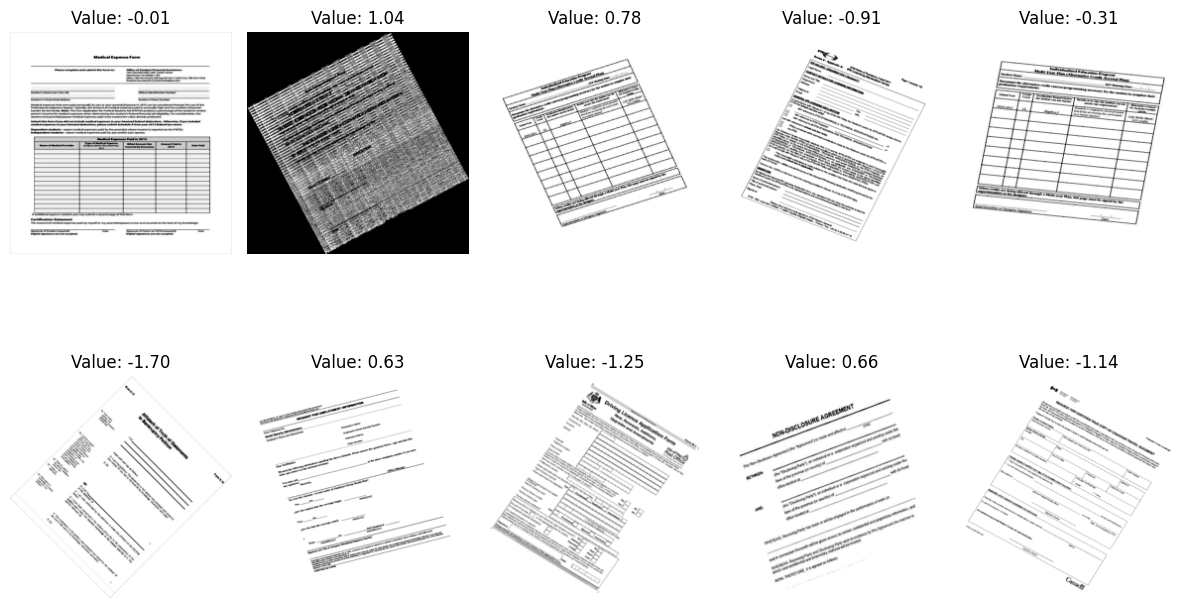

In [39]:
plot_random_images(train_dataset)
# tensor2pil(train_dataset.__getitem__(1)[0])

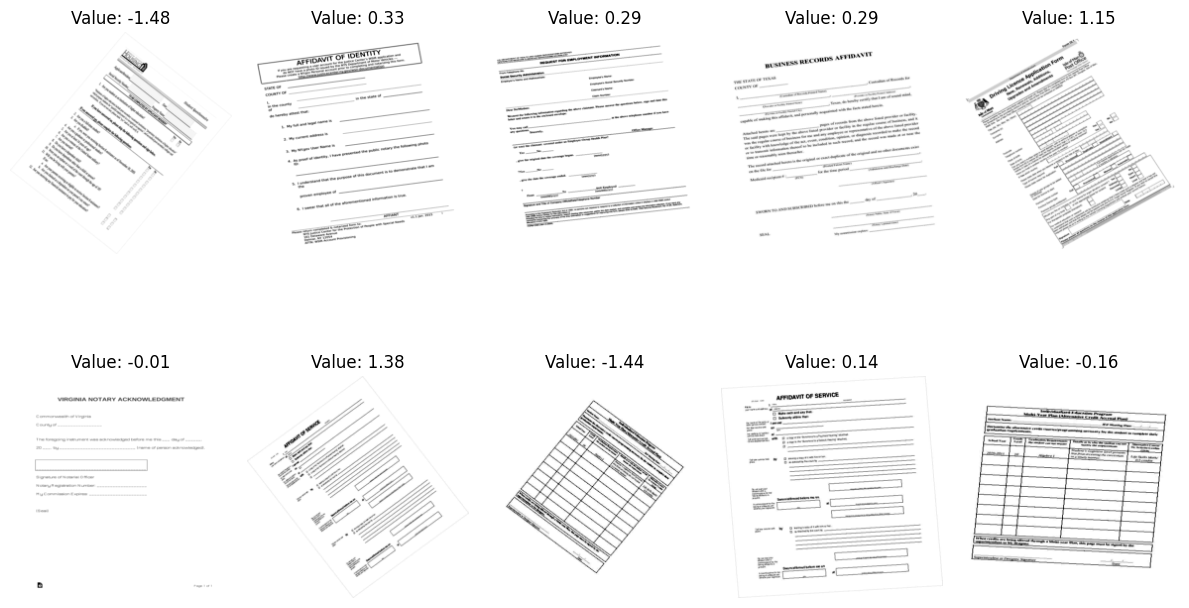

In [9]:
plot_random_images(test_dataset)

## define MODEL

In [10]:
## define model class

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.LeakyReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.batchnorm3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((2,2))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(2048, 256)
        self.linear2 = nn.Linear(256, 32)
        self.linear3 = nn.Linear(32, 1)
        

    def forward(self, x):
        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool1(x)
        x = self.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool2(x)
        x = self.relu(self.batchnorm3(self.conv3(x)))
        x = self.pool3(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x


In [12]:
## test the model
from torchsummary import summary

model = ConvNet()
# model = TimmRegressor("efficientnet_b1")
model = model.to(device)

summary(model, (1, 224, 224))

dummy_input = torch.ones(3,1,224,224, device=device)
output = model(dummy_input)
# output
total_params(model)*4/(1024*1024)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]             640
       BatchNorm2d-2         [-1, 64, 222, 222]             128
         LeakyReLU-3         [-1, 64, 222, 222]               0
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 256, 109, 109]         147,712
       BatchNorm2d-6        [-1, 256, 109, 109]             512
         LeakyReLU-7        [-1, 256, 109, 109]               0
         MaxPool2d-8          [-1, 256, 54, 54]               0
            Conv2d-9          [-1, 512, 52, 52]       1,180,160
      BatchNorm2d-10          [-1, 512, 52, 52]           1,024
        LeakyReLU-11          [-1, 512, 52, 52]               0
        MaxPool2d-12          [-1, 512, 26, 26]               0
AdaptiveMaxPool2d-13            [-1, 512, 2, 2]               0
          Flatten-14                 [-

7.106693267822266

In [14]:
# timm.list_models()

## Train 

In [22]:

class ModelModule(pl.LightningModule):
    def __init__(self, model, loss_fn, lr):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        # print(f"input shape {x.size()}, output shape {y.size()}")
        y_hat = self.model(x)
        print(f"output {y_hat.detach().cpu()}, label {y}")
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        # acc = get_acc(y_hat, y)
        # self.log('train_acc', acc, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss)
        # acc = get_acc(y_hat, y)
        # self.log('val_acc', acc, on_epoch=True, on_step=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        # return {"optimizer": optimizer, "lr_scheduler": scheduler}
        return optimizer

    def on_validation_epoch_end(self):
        metrics = self.trainer.callback_metrics
        print(f'==========> Epoch {self.current_epoch}')
        print_metrics_on_epoch_end(metrics, ['train_loss', 'val_loss'])


In [23]:
# dummy forward pass

#  for batch in train_loader:
#     x, y = batch
#     x, y = x.to(device), y.to(device)
#     y_hat = model(x).reshape(-1)
#     break

In [25]:
# load pl_module
loss_fn = nn.L1Loss()
lr = 1e-4
# model = ConvNet().to(device)
# model = TimmRegressor("densenet201").to(device)
pl_model = ModelModule(model, loss_fn, lr)

In [30]:
# define trainer

verbose=False

epochs=100
model_string = "Convnet-custom"
current_date = datetime.now(timezone('Asia/Kolkata')).strftime('%Y-%m-%d')

tb_logger = TensorBoardLogger(
    save_dir=os.path.join(root_dir, 'logs'), 
    name=f"{current_date}-rdoc_sdataset-scaled_angles-{model_string}-{round(total_params(model)/1000000,2)}m_params-{len(train_loader)*train_loader.batch_size}samples-lr{lr}-bs{train_loader.batch_size}_imgsize_400x400"
)

checkpoint_callback = ModelCheckpoint(
    dirpath=os.path.join(root_dir, 'checkpoints'),
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}-{model_string}"
)
# early_stop_callback = EarlyStopping(
#     monitor="val_loss", min_delta=0.00, patience=5, verbose=True, mode="min"
# )

trainer = pl.Trainer(
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        max_epochs=epochs, 
        logger=tb_logger, 
        log_every_n_steps=1, 
        limit_train_batches=None, 
        limit_val_batches=1,
        enable_checkpointing=False,
        # callbacks=[checkpoint_callback, early_stop_callback],
    )


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


In [31]:
trainer.fit(pl_model, train_loader, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | model   | ConvNet | 1.9 M 
1 | loss_fn | L1Loss  | 0     
------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.452     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

==========> Epoch 0
{'val_loss': 0.7}
Epoch 0:   0%|          | 0/85 [00:00<?, ?it/s]                            output tensor([[-0.4093],
        [-0.5399],
        [-0.6036],
        [-0.5420],
        [-0.6121],
        [-0.6747],
        [-0.5717],
        [-0.5488]]), label tensor([-1.5519, -0.9510, -0.5004, -0.6882,  0.7389, -1.2139,  1.4900, -0.3877],
       device='cuda:0')
Epoch 0:   1%|          | 1/85 [00:00<00:38,  2.16it/s, loss=0.721, v_num=3]output tensor([[-1.1817],
        [-1.1845],
        [-1.4487],
        [-1.0901],
        [-1.0345],
        [-0.9459],
        [-0.8438],
        [-0.8289]]), label tensor([-0.7633,  0.3258, -1.6646, -0.3126, -0.7257,  1.1895,  1.3022,  0.2507],
       device='cuda:0')
Epoch 0:   2%|▏         | 2/85 [00:00<00:28,  2.96it/s, loss=0.945, v_num=3]output tensor([[-0.7759],
        [-0.4861],
        [-0.6883],
        [-0.6955],
        [-0.4619],
        [-0.7788],
        [-0.4810],
        [-0.7104]]), label tensor([ 0.7765, -1.3266

## custom train code

In [31]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.global_maxpool = nn.AdaptiveMaxPool2d(1)
        
        self.fc1 = nn.Linear(64, 512)
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.global_maxpool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

# c_model = CustomModel()
# loss_fn = nn.L1Loss()
# optimizer = torch.optim.Adam(c_model.parameters(), lr=0.0005)

In [33]:
## custom train code

epochs = 500
loss_fn = nn.L1Loss()
lr = 0.0005

log_every = 20

# model = ConvNet()
# model = TimmRegressor("densenet121").to(device)
# model = model.to(device)
c_model = CustomModel().to(device)
optimizer = torch.optim.Adam(c_model.parameters(), lr=lr)


# from torch.utils.data import Subset
# subset_indices = [1,2,3,4]
# subset_dataset = Subset(train_dataset, subset_indices)
# dummy_loader = DataLoader(subset_dataset, batch_size=4, shuffle=False, num_workers=2)



train_dataset = SkewDataset("/home/deepam_minda_farmart_co/fmt/skew_correction/data/rotated/rdocuments/train_scaled.csv", split="train")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=1)

model.train()
for epoch in tqdm(range(epochs)):
    running_loss = 0
    for idx, batch in enumerate(train_loader):
        x, y = batch
        # print(f"input shape {x.size()}, output shape {y.size()}")
        x, y = x.to(device), y.to(device)
        y_hat = c_model(x)

        optimizer.zero_grad()
        # print(f"output {y_hat.detach().cpu()}, label {y.detach().cpu()}")
        
        loss = loss_fn(y_hat, y)
        running_loss += loss.item()
        
        if idx%log_every==0:
            print('train_loss', loss.item())

        loss.backward()
        optimizer.step()
    
    average_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}] - Average Loss: {average_loss:.4f}")
    # acc = get_acc(y_hat, y)
    # self.log('train_acc', acc, on_epoch=True, on_step=True)
    
    

  0%|          | 0/500 [00:00<?, ?it/s]

train_loss 0.9255192875862122


  0%|          | 1/500 [00:05<46:13,  5.56s/it]

train_loss 0.6374555826187134
Epoch [1/500] - Average Loss: 0.8693
train_loss 0.9253004789352417


  0%|          | 2/500 [00:11<46:24,  5.59s/it]

train_loss 0.6388514041900635
Epoch [2/500] - Average Loss: 0.8692
train_loss 0.9252161979675293


  1%|          | 3/500 [00:16<46:01,  5.56s/it]

train_loss 0.6387450098991394
Epoch [3/500] - Average Loss: 0.8691
train_loss 0.9252965450286865


  1%|          | 4/500 [00:22<46:20,  5.61s/it]

train_loss 0.6419801712036133
Epoch [4/500] - Average Loss: 0.8695
train_loss 0.9256327152252197


  1%|          | 4/500 [00:27<56:59,  6.89s/it]


KeyboardInterrupt: 

In [27]:
# dir(dummy_loader)


# more things to try - 
- [ ] ~~normalize image~~
- [ ] ~~batchnorm~~
- [ ] ~~more augmentations~~
- [ ] cleaning data
- ~~different lr (e-4, e-5 )~~
- [ ] increase image size  
~~!!shuffle off for overfitting~~
- [ ] target variable scaling
- [ ] try on dummy data (rdocumnets..)
- [ ] -45 to 45 .. ?
- [ ] MAE loss instead of MSE

In [24]:
# total_params(timm.create_model("densenet201"))
dir(train_dataset)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'df',
 'filepaths',
 'labels',
 'split']

## timm-regressors

In [27]:
import timm
class TimmRegressor(nn.Module):
    def __init__(self, model_name, pretrained=True, in_chans=1, dropout=0.0):
        super(TimmRegressor, self).__init__()
        self.backbone = timm.create_model(
            model_name, 
            pretrained=pretrained, 
            in_chans=in_chans,
            drop_rate=dropout
        )
        self.regression_head = nn.Sequential(
            nn.Linear(self.backbone.num_classes, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 1),
        )
        # self.lr = lr
        
    def forward(self, x):

        # out = F.relu(self.backbone(x))

        # out = F.softmax(out, dim=1)
        out = self.backbone(x)
        out = self.regression_head(out)

        return out
    
    # def predict(self, x):
    #     self.eval()  # Set the model to evaluation mode

    #     # we need 4 dims
    #     if len(x.shape)==3:
    #         x = x.unsqueeze(0)

    #     with torch.no_grad():
    #         logits = self.forward(x)
    #         probabilities = F.softmax(logits, dim=1)
    #         _, predicted_classes = torch.max(probabilities, dim=1)
        
    #     if not predicted_classes.device==torch.device('cpu'):
    #         predicted_classes.to('cpu')

    #     return predicted_classes
    
    # def load(self, ckpt_path, device='auto'):
        
    #     if device=='auto':
    #         device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #     self.load_state_dict(torch.load(ckpt_path, map_location=device))


In [29]:
backbone = timm.create_model(
            "densenet121", 
            pretrained=True, 
            in_chans=1,
            drop_rate=0
        )
sample = train_dataset.__getitem__(2)
output = backbone(sample[0].unsqueeze(0))
regression_head = nn.Sequential(
    nn.Linear(backbone.num_classes, 512),
    nn.ReLU(),
    nn.Dropout(0),
    nn.Linear(512, 1)
)

In [45]:
# model = TimmRegressor("densenet121")
# model(sample[0].unsqueeze(0))_ 
# total_params(model)